## Data Cleaning

In [1]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from sklearn import preprocessing
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
import scipy 
from scipy import stats
import math
from math import sqrt


### The Movie Data Base

In [2]:
# read data in
tmdb = pd.read_csv('Data/tmdb.movies.csv', index_col=0)
tmdb.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [3]:
tmdb.shape

(26517, 9)

In [4]:
tmdb.isna().any()

genre_ids            False
id                   False
original_language    False
original_title       False
popularity           False
release_date         False
title                False
vote_average         False
vote_count           False
dtype: bool

In [5]:
tmdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26517 entries, 0 to 26516
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   genre_ids          26517 non-null  object 
 1   id                 26517 non-null  int64  
 2   original_language  26517 non-null  object 
 3   original_title     26517 non-null  object 
 4   popularity         26517 non-null  float64
 5   release_date       26517 non-null  object 
 6   title              26517 non-null  object 
 7   vote_average       26517 non-null  float64
 8   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 2.0+ MB


Here we can see that our release date isn't being treated as a datetime object. The genre IDs will also be more useful as lists rather than strings

In [6]:
# change release date to datetime
tmdb.release_date = pd.to_datetime(tmdb.release_date)
# turn genre ids into lists
tmdb.genre_ids = tmdb.genre_ids.str.strip('[]').str.split(',')
# remove whitespace from genre ids
tmdb.genre_ids = tmdb.genre_ids.apply(lambda x: [y.strip() for y in x])
# add release month column
tmdb['release_month'] = tmdb.release_date.dt.month
tmdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   genre_ids          26517 non-null  object        
 1   id                 26517 non-null  int64         
 2   original_language  26517 non-null  object        
 3   original_title     26517 non-null  object        
 4   popularity         26517 non-null  float64       
 5   release_date       26517 non-null  datetime64[ns]
 6   title              26517 non-null  object        
 7   vote_average       26517 non-null  float64       
 8   vote_count         26517 non-null  int64         
 9   release_month      26517 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 2.2+ MB


In [7]:
ids = []
genre_ids = []
vote_averages = []
 
popularity_by_genre = {'id': ids, 'genre_ids': genre_ids, 'vote_average': vote_averages}
 
for index, row in tmdb.iterrows():
    for genre in row[0]:
        ids.append(row[1])
        genre_ids.append(genre)
        vote_averages.append(row[7])
 
popularity_by_genre = pd.DataFrame(popularity_by_genre)
popularity_by_genre.head()

,id,genre_ids,vote_average
0,12444,12,7.7
1,12444,14,7.7
2,12444,10751,7.7
3,10191,14,7.7
4,10191,12,7.7


In [8]:
# get unique set of genres
genres = set(tmdb.genre_ids.sum())
# convert genre ids list back to string
tmdb.genre_ids = tmdb.genre_ids.astype(str)
# check if string contains the genre
for genre in genres:
    tmdb[genre] = tmdb.genre_ids.str.contains(genre)

In [9]:
tmdb.shape

(26517, 30)

In [10]:
# rename columns for genres
genre_mappings = {
    '28': 'Action',
    '12': 'Adventure',
    '16': 'Animation',
    '35': 'Comedy',
    '80': 'Crime',
    '99': 'Documentary',
    '18': 'Drama',
    '10751': 'Family',
    '14': 'Fantasy',
    '36': 'History',
    '27': 'Horror',
    '10402': 'Music',
    '9648': 'Mystery',
    '10749': 'Romance',
    '878': 'Science Fiction',
    '10770': 'TV Movie',
    '53': 'Thriller',
    '10752': 'War',
    '37': 'Western'
}

tmdb = tmdb.rename(columns=genre_mappings)
tmdb.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,release_month,...,Documentary,Drama,History,Mystery,Horror,Animation,Thriller,Action,TV Movie,War
0,"['12', '14', '10751']",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,11,...,False,False,False,False,False,False,False,False,False,False
1,"['14', '12', '16', '10751']",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,3,...,False,False,False,False,False,True,False,False,False,False
2,"['12', '28', '878']",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,5,...,False,False,False,False,False,False,False,True,False,False
3,"['16', '35', '10751']",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174,11,...,False,False,False,False,False,True,False,False,False,False
4,"['28', '878', '12']",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186,7,...,False,False,False,False,False,False,False,True,False,False


In [11]:
tmdb.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,release_month,...,Documentary,Drama,History,Mystery,Horror,Animation,Thriller,Action,TV Movie,War
0,"['12', '14', '10751']",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,11,...,False,False,False,False,False,False,False,False,False,False
1,"['14', '12', '16', '10751']",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,3,...,False,False,False,False,False,True,False,False,False,False
2,"['12', '28', '878']",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,5,...,False,False,False,False,False,False,False,True,False,False
3,"['16', '35', '10751']",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174,11,...,False,False,False,False,False,True,False,False,False,False
4,"['28', '878', '12']",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186,7,...,False,False,False,False,False,False,False,True,False,False


In [12]:
tmdb.describe()

,id,popularity,vote_average,vote_count,release_month
count,26517.000000,26517.000000,26517.000000,26517.000000,26517.000000
mean,295050.153260,3.130912,5.991281,194.224837,6.405966
std,153661.615648,4.355229,1.852946,960.961095,3.573796
min,27.000000,0.600000,0.000000,1.000000,1.000000
25%,157851.000000,0.600000,5.000000,2.000000,3.000000
50%,309581.000000,1.374000,6.000000,5.000000,6.000000
75%,419542.000000,3.694000,7.000000,28.000000,10.000000
max,608444.000000,80.773000,10.000000,22186.000000,12.000000


Here we can see that many of the movies have very few votes under vote count which may influence the overall rating for that movie. We should make sure that there are a reasonable amount of votes before continuing with our analysis

In [13]:
# remove rows where there are fewer than 28 votes
tmdb_final = tmdb.query('vote_count >= 100').copy()
print(tmdb_final.shape)
tmdb_final.describe()

(3686, 30)


,id,popularity,vote_average,vote_count,release_month
count,3686.000000,3686.000000,3686.000000,3686.000000,3686.000000
mean,223283.718394,11.281023,6.389392,1325.535269,6.974498
std,144382.238450,6.196958,0.862305,2270.643058,3.449799
min,27.000000,0.600000,2.000000,100.000000,1.000000
25%,78090.500000,7.557750,5.800000,186.000000,4.000000
50%,234102.000000,9.395000,6.400000,422.000000,7.000000
75%,339966.250000,12.894000,7.000000,1306.000000,10.000000
max,569547.000000,80.773000,8.600000,22186.000000,12.000000


### Movie Budgets

In [14]:
movie_budgets = pd.read_csv('Data/tn.movie_budgets.csv')
print(movie_budgets.shape)
movie_budgets.head()

(5782, 6)


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [15]:
movie_budgets.isna().any()

id                   False
release_date         False
movie                False
production_budget    False
domestic_gross       False
worldwide_gross      False
dtype: bool

In [16]:
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [17]:
movie_budgets['production_budget'] = (movie_budgets['production_budget']
                                      .str.replace(',', '')
                                      .str.replace('$', '')
                                      .astype(float))

movie_budgets['domestic_gross'] = (movie_budgets['domestic_gross']
                                   .str.replace(',', '')
                                   .str.replace('$', '')
                                   .astype(float))

movie_budgets['worldwide_gross'] = (movie_budgets['worldwide_gross']
                                    .str.replace(',', '')
                                    .str.replace('$', '')
                                    .astype(float))

In [18]:
movie_budgets['release_date'] = pd.to_datetime(movie_budgets['release_date'])

### Combined TMDB and Budgets

In [19]:
tmdb_with_budgets = pd.merge(tmdb, movie_budgets,  how='inner', left_on=['title','release_date'], right_on = ['movie','release_date'])

In [20]:
tmdb_with_budgets['income'] = tmdb_with_budgets.worldwide_gross - tmdb_with_budgets.production_budget

In [21]:
tmdb_with_budgets.sort_values('income', ascending=False)

,genre_ids,id_x,original_language,original_title,popularity,release_date,title,vote_average,vote_count,release_month,...,Thriller,Action,TV Movie,War,id_y,movie,production_budget,domestic_gross,worldwide_gross,income
5,"['28', '12', '14', '878']",19995,en,Avatar,26.526,2009-12-18,Avatar,7.4,18676,12,...,False,True,False,False,1,Avatar,425000000.0,760507625.0,2.776345e+09,2.351345e+09
1285,"['12', '28', '14']",299536,en,Avengers: Infinity War,80.773,2018-04-27,Avengers: Infinity War,8.3,13948,4,...,False,True,False,False,7,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,1.748134e+09
755,"['28', '12', '878', '53']",135397,en,Jurassic World,20.709,2015-06-12,Jurassic World,6.6,14056,6,...,True,True,False,False,34,Jurassic World,215000000.0,652270625.0,1.648855e+09,1.433855e+09
760,"['28', '80', '53']",168259,en,Furious 7,20.396,2015-04-03,Furious 7,7.3,6538,4,...,True,True,False,False,67,Furious 7,190000000.0,353007020.0,1.518723e+09,1.328723e+09
297,"['878', '28', '12']",24428,en,The Avengers,50.289,2012-05-04,The Avengers,7.6,19673,5,...,False,True,False,False,27,The Avengers,225000000.0,623279547.0,1.517936e+09,1.292936e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1392,"['18', '10752', '28', '12']",345934,en,Air Strike,6.971,2018-10-26,Air Strike,3.9,56,10,...,False,True,False,True,21,Air Strike,65000000.0,0.0,5.162790e+05,-6.448372e+07
106,"['10402', '14', '28', '10751']",49852,en,The Nutcracker in 3D,7.566,2010-11-24,The Nutcracker in 3D,5.5,97,11,...,False,True,False,False,79,The Nutcracker in 3D,90000000.0,195459.0,2.046602e+07,-6.953398e+07
1061,"['36', '10749', '18']",354859,en,The Promise,10.158,2017-04-21,The Promise,7.1,195,4,...,False,False,False,False,78,The Promise,90000000.0,8224288.0,1.055142e+07,-7.944858e+07
1062,"['36', '10749', '18']",354859,en,The Promise,10.158,2017-04-21,The Promise,7.1,195,4,...,False,False,False,False,78,The Promise,90000000.0,8224288.0,1.055142e+07,-7.944858e+07


Text(0.5, 1.0, 'Production Budget and Income')

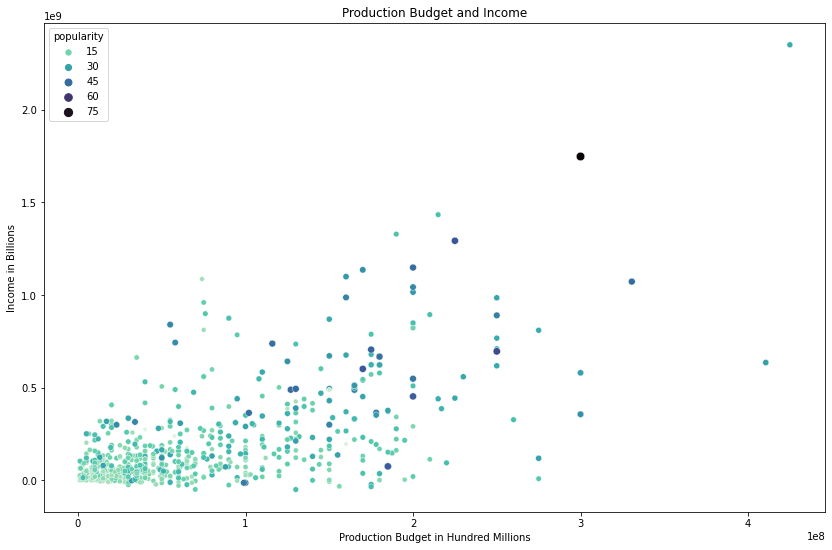

In [22]:
fig, ax = plt.subplots(figsize = (14, 9))

sns.scatterplot(data=tmdb_with_budgets.query('vote_count > 1000'),
                x='production_budget',
                y='income',
                size='popularity',
                hue='popularity',
                ax=ax,
                palette='mako_r');

ax.set_xlabel("Production Budget in Hundred Millions")
ax.set_ylabel("Income in Billions")
ax.set_title('Production Budget and Income')

In [23]:
tmdb_with_budgets[['production_budget', 'income']].corr()

,production_budget,income
production_budget,1.00000,0.67949
income,0.67949,1.00000


In [24]:
genres_with_budgets = popularity_by_genre.merge(tmdb_with_budgets, how='inner', left_on='id', right_on='id_x')

columns = ['genre_ids_x',
           'vote_average_x',
           'popularity',
           'vote_count',
           'production_budget',
           'domestic_gross',
           'worldwide_gross',
           'income']

genres_with_budgets = genres_with_budgets[columns]
genres_with_budgets = genres_with_budgets.rename({'genre_ids_x': 'genre_id', 'vote_average_x': 'vote_average'}, axis=1)
genres_with_budgets.head()

,genre_id,vote_average,popularity,vote_count,production_budget,domestic_gross,worldwide_gross,income
0,14,7.7,28.734,7610,165000000.0,217581232.0,494870992.0,329870992.0
1,12,7.7,28.734,7610,165000000.0,217581232.0,494870992.0,329870992.0
2,16,7.7,28.734,7610,165000000.0,217581232.0,494870992.0,329870992.0
3,10751,7.7,28.734,7610,165000000.0,217581232.0,494870992.0,329870992.0
4,12,6.8,28.515,12368,170000000.0,312433331.0,621156389.0,451156389.0


In [25]:
genres_with_budgets.genre_id = genres_with_budgets.genre_id.map(genre_mappings)
genre_averages = genres_with_budgets.groupby('genre_id').mean().sort_values('income', ascending=False)
genre_averages.head(10)

,vote_average,popularity,vote_count,production_budget,domestic_gross,worldwide_gross,income
genre_id,,,,,,,
Animation,6.711111,16.240342,3424.880342,9.518376e+07,1.378979e+08,3.739110e+08,2.787272e+08
Adventure,6.504230,19.323686,4654.873112,1.134583e+08,1.374754e+08,3.907087e+08,2.772504e+08
Fantasy,6.394118,19.281417,4215.647059,1.040430e+08,1.270266e+08,3.574261e+08,2.533830e+08
Family,6.552105,15.233226,3007.821053,8.684553e+07,1.208917e+08,3.176784e+08,2.308329e+08
Science Fiction,6.323810,18.694014,4853.719048,9.276986e+07,1.129227e+08,3.091587e+08,2.163889e+08
Action,6.279358,18.161101,3712.743119,8.704817e+07,9.968202e+07,2.760364e+08,1.889883e+08
Comedy,6.335382,12.532549,1969.839851,4.141917e+07,6.486211e+07,1.513059e+08,1.098867e+08
Western,6.730435,15.033522,4700.173913,5.777391e+07,6.424929e+07,1.642734e+08,1.064995e+08
War,6.670213,13.914851,2477.914894,4.570426e+07,6.967872e+07,1.385586e+08,9.285438e+07


This is a quick breakdown of our average key values grouped by genre

<ipython-input-26-f77145c739b7>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(0, 301, 50));


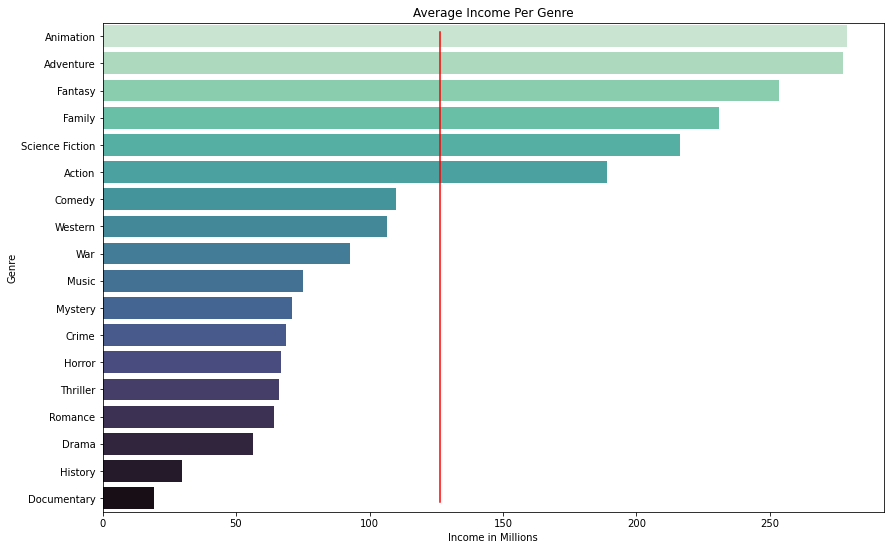

In [26]:
fig, ax = plt.subplots(figsize = (14, 9))

sns.barplot(data=genre_averages,
            x='income' ,
            y=genre_averages.index,
            ax=ax,
            palette='mako_r')

ax.set_xlabel("Income in Millions")
ax.set_ylabel("Genre")
ax.set_title('Average Income Per Genre')
plt.axvline(x=genre_averages.income.mean(),
            ymin=0.02,
            ymax=0.98,
            color='red')
ax.set_xticklabels(np.arange(0, 301, 50));

This is a heatmap that breaks down each genre to show profit at each rating, in billions. This is visualizing how some genres are only really profitable if reception is majorly positive, some genres are profitable consistently over a larger variety of ratings, and some genres simply are not profitable regardless of ratings.

In [27]:
# Converts income to be read in billions and rounds to 1 decimal place
genres_with_budgets['incomebillions'] = round(genres_with_budgets['income']/1000000000, 1)

# As a precaution for any variance, rounds all vote rating to 1 decimal place
genres_with_budgets['int_vote_avg'] = round(genres_with_budgets['vote_average'], 1)

# Sets a filter on the vote average to range between 5.7 and 8.3, due to all values beneath 5.7 yielding similar results to values less than 6, and no data existing for ratings higher than 8.3
genres_with_budgets = genres_with_budgets[(genres_with_budgets['int_vote_avg']>=5.7) & (genres_with_budgets['int_vote_avg']<=8.3)]

# Generates a new table with only the above values for use in the heatmap below
heatmap_df = pd.pivot_table(genres_with_budgets, index='genre_id', columns='int_vote_avg', values='incomebillions')
heatmap_df = heatmap_df.fillna(0)

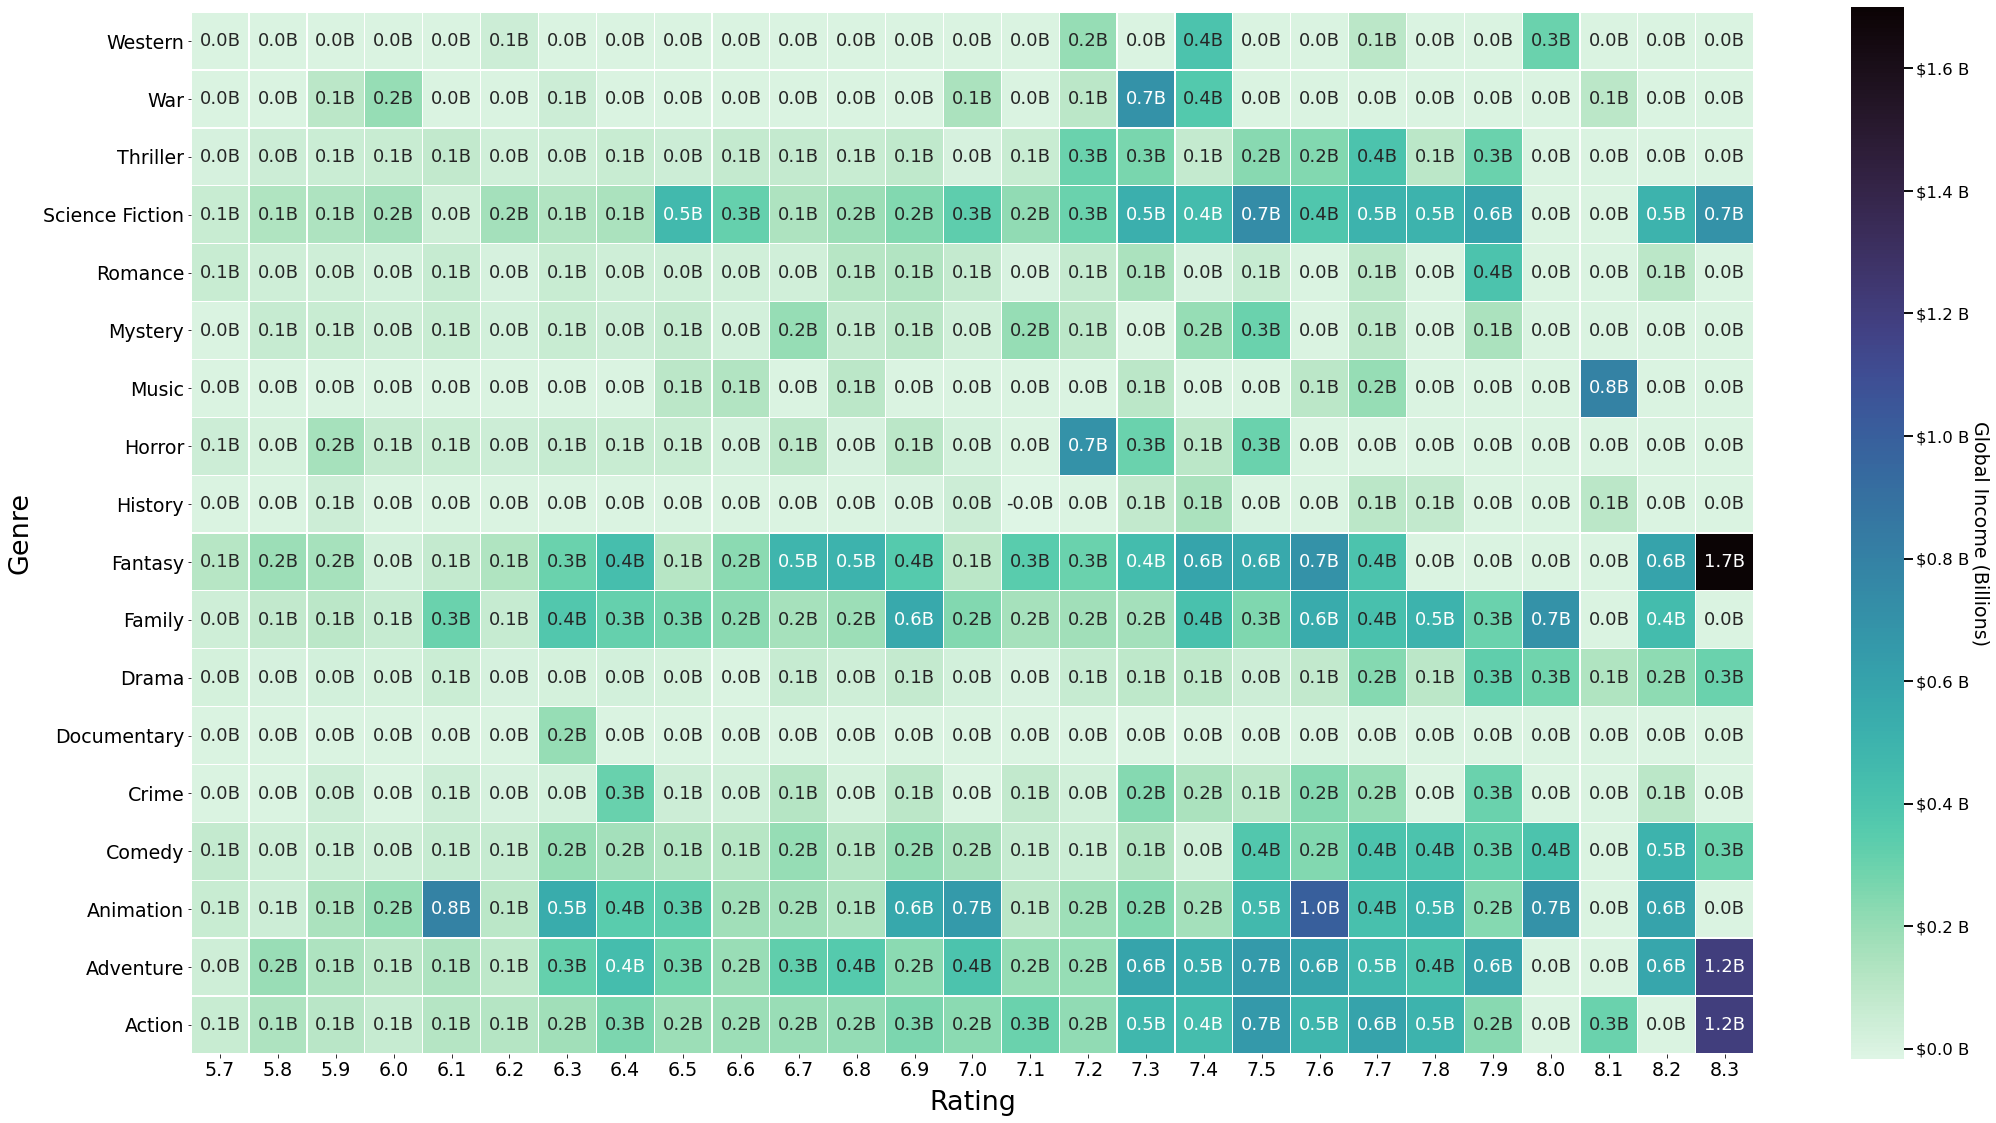

In [28]:
# Creates size and subplot for the heatmap figure
fig = plt.figure(figsize=(35,55))
ax = fig.add_subplot(1,1,1)

# Automatically adds text to the color bar values on the right
comma_fmt = FuncFormatter(lambda x, p: format("$" + str(round(float(x), 1)) + " B"))

# Improves readability on smaller computers
sns.set_context("talk")

# Generates a heatmap with proper theme, linewidth, annotation, and cbar formatting. Sets the heatmap to a variable for future reference
ax = sns.heatmap(heatmap_df, linewidth=0.2, annot=True, cmap='mako_r',
                 fmt=',.1f', square=True, annot_kws={'size': 18},
                 cbar_kws={'format': comma_fmt, 'orientation':'vertical', 'shrink':.3518})

# Adds a 'B' to the end of each value in each square of the heatmap to indicate the number measures in billions
for t in ax.texts:
    t.set_text(t.get_text() + "B")

# Sets labels for x-axis, y-axis, and the title of the chart
plt.xlabel("Rating", fontsize=27, labelpad=10)
plt.ylabel("Genre", fontsize=27, labelpad=10)
plt.yticks(rotation=0, fontsize=19)
plt.xticks(size=19)

# Flips the y-axis to align values accurately
ax.invert_yaxis()

# Creates a colorbar, labels it, and formats it
cbar = ax.collections[0].colorbar
cbar.set_label("Global Income (Billions)", rotation=270, fontsize=19, color='black', labelpad=20)
cbar.config_axis()

plt.show()

# Conducting Z-tests on top performing genres

State the Hypothesis

Taking 6 different samples of 50 movies from the top genres Adventure, Animation, Fantasy, Family, Science Fiction, and Action to compare the movie sample income to the general population movie income.

Alternative Hypothesis: The sample genre mean income is significantly bigger than the population mean.

Null Hypothesis: There is no significant difference between the sample genre mean income and population mean income. 

In this case income = (domestic gross + world wide gross) - production budget

In [29]:
adventure = tmdb_with_budgets[tmdb_with_budgets['Adventure']==True]
animation = tmdb_with_budgets[tmdb_with_budgets['Animation']==True]
fantasy = tmdb_with_budgets[tmdb_with_budgets['Fantasy']==True]
family = tmdb_with_budgets[tmdb_with_budgets['Family']==True]
scifi = tmdb_with_budgets[tmdb_with_budgets['Science Fiction']==True]
action = tmdb_with_budgets[tmdb_with_budgets['Action']==True]

Adventure movies

In [30]:
# take a random sample of the adventure movies income to compare to population income
sample = adventure['income'].sample(n=50)
# find the genre population mean 
mu = tmdb_with_budgets['income'].mean()
mu
# find the sample popularity mean
x_bar = sample.mean()
# sample std (sigma)
sigma = np.std(sample)
# sample size 
n = len(sample)
# calculate the z
z = (x_bar - mu)/(sigma/sqrt(n))
z

3.637313907045779

In [31]:
# Print the findings
print(f"""
The sample contains {n} observations, having a mean of {x_bar}
billion dollars and a standard deviation (sigma) of {round(sigma,3)} billion dollars.
""")


The sample contains 50 observations, having a mean of 312981718.78
billion dollars and a standard deviation (sigma) of 409399420.134 billion dollars.



In [32]:
stats.norm.cdf(z)

0.9998622519495188

In [33]:
# Interpret p-value
pval = 1 - stats.norm.cdf(z)
pval 

0.0001377480504811679

Our p-value (8.501e-05) is smaller than the alpha of 0.05. There is enough evidence to reject the null hypothesis given this sample with an alpha of 0.05. Given this evidence, there is a significant difference between the adventure income mean and the population income mean. The results show a significant increase in income as the result of the genre. 

Animation

In [34]:
# take a random sample of the animation movies income to compare to population income
sample = animation['income'].sample(n=50)
# find the genre population mean 
mu = tmdb_with_budgets['income'].mean()
mu
# find the sample popularity mean
x_bar = sample.mean()
# sample std (sigma)
sigma = np.std(sample)
# sample size 
n = len(sample)
# calculate the z
z = (x_bar - mu)/(sigma/sqrt(n))
z

4.5851510021616795

In [35]:
# Print the findings
print(f"""
The sample contains {n} observations, having a mean of {x_bar}
billion dollars and a standard deviation (sigma) of {round(sigma,3)} billion dollars.
""")


The sample contains 50 observations, having a mean of 276188142.06
billion dollars and a standard deviation (sigma) of 268027013.24 billion dollars.



In [36]:
# calculate the p-value
stats.norm.cdf(z)

0.9999977317077483

In [37]:
# Interpret p-value
pval = 1 - stats.norm.cdf(z)
pval 

2.2682922516947812e-06

Our p-value (4.4979e-06) is smaller than the alpha of 0.05. There is enough evidence to reject the null hypothesis given this sample with an alpha of 0.05. Given this evidence, there is a significant difference between the animation income mean and the population income mean. The results show a significant increase in income as the result of the genre.

Fantasy

In [38]:
# take a random sample of the fantasy movies income to compare to population income
sample = fantasy['income'].sample(n=50)
# find the genre population mean 
mu = tmdb_with_budgets['income'].mean()
mu
# find the sample popularity mean
x_bar = sample.mean()
# sample std (sigma)
sigma = np.std(sample)
# sample size 
n = len(sample)
# calculate the z
z = (x_bar - mu)/(sigma/sqrt(n))
z

2.534842313298119

In [39]:
# Print the findings
print(f"""
The sample contains {n} observations, having a mean of {x_bar}
billion dollars and a standard deviation (sigma) of {round(sigma,3)} billion dollars.
""")


The sample contains 50 observations, having a mean of 186748279.6
billion dollars and a standard deviation (sigma) of 235323906.617 billion dollars.



In [40]:
# calculate the pvalue
stats.norm.cdf(z)

0.994375102331839

In [41]:
# Interpret p-value
pval = 1 - stats.norm.cdf(z)
pval 

0.005624897668160989

Our p-value (0.001138) is smaller than the alpha of 0.05. There is enough evidence to reject the null hypothesis given this sample with an alpha of 0.05. Given this evidence, there is a significant difference between the fantasy income mean and the population income mean. The results show a significant increase in income as the result of the genre.

Family

In [42]:
# take a random sample of the family movies income to compare to population income
sample = family['income'].sample(n=50)
# find the genre population mean 
mu = tmdb_with_budgets['income'].mean()
mu
# find the sample popularity mean
x_bar = sample.mean()
# sample std (sigma)
sigma = np.std(sample)
# sample size 
n = len(sample)
# calculate the z
z = (x_bar - mu)/(sigma/sqrt(n))
z

3.2577769074101037

In [43]:
# Print the findings
print(f"""
The sample contains {n} observations, having a mean of {x_bar}
billion dollars and a standard deviation (sigma) of {round(sigma,3)} billion dollars.
""")


The sample contains 50 observations, having a mean of 238335874.1
billion dollars and a standard deviation (sigma) of 295074955.132 billion dollars.



In [44]:
# calculate the p-value
stats.norm.cdf(z)

0.9994385567741242

In [45]:
# Interpret p-value
pval = 1 - stats.norm.cdf(z)
pval 

0.0005614432258758129

Our p-value (0.005901) is smaller than the alpha of 0.05. There is enough evidence to reject the null hypothesis given this sample with an alpha of 0.05. Given this evidence, there is a significant difference between the family income mean and the population income mean. The results show a significant increase in income as the result of the genre.

Science Fiction

In [46]:
# take a random sample of the Science Fiction movies income to compare to population income
sample = scifi['income'].sample(n=50)
# find the genre population mean 
mu = tmdb_with_budgets['income'].mean()
mu
# find the sample popularity mean
x_bar = sample.mean()
# sample std (sigma)
sigma = np.std(sample)
# sample size 
n = len(sample)
# calculate the z
z = (x_bar - mu)/(sigma/sqrt(n))
z

2.3180747988618786

In [47]:
# Print the findings
print(f"""
The sample contains {n} observations, having a mean of {x_bar}
billion dollars and a standard deviation (sigma) of {round(sigma,3)} billion dollars.
""")


The sample contains 50 observations, having a mean of 189765758.96
billion dollars and a standard deviation (sigma) of 266534020.948 billion dollars.



In [48]:
# calculate the p-value
stats.norm.cdf(z)

0.9897773718669631

In [49]:
# Interpret p-value
pval = 1 - stats.norm.cdf(z)
pval 

0.01022262813303687

Our p-value (0.00915) is smaller than the alpha of 0.05. There is enough evidence to reject the null hypothesis given this sample with an alpha of 0.05. Given this evidence, there is a significant difference between the science fiction income mean and the population income mean. The results show a significant increase in income as the result of the genre.

Action

In [50]:
# take a random sample of the Science Fiction movies income to compare to population income
sample = action['income'].sample(n=50)
# find the genre population mean 
mu = tmdb_with_budgets['income'].mean()
mu
# find the sample popularity mean
x_bar = sample.mean()
# sample std (sigma)
sigma = np.std(sample)
# sample size 
n = len(sample)
# calculate the z
z = (x_bar - mu)/(sigma/sqrt(n))
z

1.7342863162584385

In [51]:
# Print the findings
print(f"""
The sample contains {n} observations, having a mean of {x_bar}
billion dollars and a standard deviation (sigma) of {round(sigma,3)} billion dollars.
""")


The sample contains 50 observations, having a mean of 167967086.68
billion dollars and a standard deviation (sigma) of 267375636.163 billion dollars.



In [52]:
# calculate the p-value
stats.norm.cdf(z)

0.9585663529059643

In [53]:
# Interpret p-value
pval = 1 - stats.norm.cdf(z)
pval 

0.04143364709403574

Our p-value (0.00189) is smaller than the alpha of 0.05. There is enough evidence to reject the null hypothesis given this sample with an alpha of 0.05. Given this evidence, there is a significant difference between the action income mean and the population income mean. The results show a significant increase in income as the result of the genre.

# SQL Data Cleaning, Analysis ,and Visualization

In [54]:
import pandas as pd 
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Loading Data into Tables

Load Data set and read first one

In [55]:
conn = sqlite3.connect('Data/im.db')
df1=pd.read_sql('Select * from movie_basics', conn)
df1

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,None


Load second data set and only take the number of votes greater than 25 because this can cause the rating to be skewed if only a few people had voted for it

In [56]:
df2=pd.read_sql('Select * from movie_ratings Where numvotes>25', conn)
df2

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1043726,4.2,50352
3,tt1069246,6.2,326
4,tt1094666,7.0,1613
...,...,...,...
45752,tt9633108,3.9,44
45753,tt9668598,5.5,317
45754,tt9690762,5.6,37
45755,tt9768966,8.6,27


Load third and fourth data sets 

In [57]:
df3=pd.read_sql('Select * from directors', conn)
df3

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0462036,nm1940585
2,tt0835418,nm0151540
3,tt0835418,nm0151540
4,tt0878654,nm0089502
...,...,...
291169,tt8999974,nm10122357
291170,tt9001390,nm6711477
291171,tt9001494,nm10123242
291172,tt9001494,nm10123248


In [58]:
df4=pd.read_sql('Select * from persons', conn)
df4

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"
...,...,...,...,...,...
606643,nm9990381,Susan Grobes,NaN,NaN,actress
606644,nm9990690,Joo Yeon So,NaN,NaN,actress
606645,nm9991320,Madeline Smith,NaN,NaN,actress
606646,nm9991786,Michelle Modigliani,NaN,NaN,producer


Join tables to get necessary values and query on number of votes greater than 100 so that we can get accurate ratings and Runtime <400 because there were outliers in the thousands and almost all box office hits are below this figure

In [59]:
df=pd.read_sql('Select movie_basics.movie_id,movie_basics.primary_title,movie_basics.original_title,movie_basics.start_year,movie_basics.runtime_minutes,movie_basics.genres,movie_ratings.averagerating,movie_ratings.numvotes from movie_basics join movie_ratings Using(movie_id) Where numvotes>100 AND runtime_minutes<400 Order By numvotes', conn)
df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt1311083,Rat Scratch Fever,Rat Scratch Fever,2011,90.0,"Horror,Sci-Fi",4.9,101
1,tt1547089,A Yakuza's Daughter Never Cries,Doch yakudzy,2010,81.0,Comedy,5.1,101
2,tt1652295,Alien Inhabitant,Alien Inhabitant,2011,90.0,"Crime,Drama,Fantasy",4.4,101
3,tt1698653,"Me & Mr Jones, a love story on Natalee-island",Me and Mr Jones on Natalee-Island,2011,88.0,"Crime,Drama,Mystery",3.5,101
4,tt1711475,The Jade and the Pearl,Fei cui ming zhu,2010,104.0,"Comedy,Romance",4.2,101
...,...,...,...,...,...,...,...,...
27866,tt0848228,The Avengers,The Avengers,2012,143.0,"Action,Adventure,Sci-Fi",8.1,1183655
27867,tt1853728,Django Unchained,Django Unchained,2012,165.0,"Drama,Western",8.4,1211405
27868,tt0816692,Interstellar,Interstellar,2014,169.0,"Adventure,Drama,Sci-Fi",8.6,1299334
27869,tt1345836,The Dark Knight Rises,The Dark Knight Rises,2012,164.0,"Action,Thriller",8.4,1387769


Create another df to get just the directors and how well the directors movies did. Made sure that the director had a minimum of 10 movies made to ensure that they had a large enough sample size. Join on persons to get director name,join on movie_ratings to get average score

In [60]:
#df_directors=pd.read_sql('Select DISTINCT directors.movie_id,directors.person_id as director_id,movie_basics.primary_title,movie_basics.original_title,movie_basics.start_year,movie_basics.runtime_minutes,movie_basics.genres,movie_ratings.averagerating,movie_ratings.numvotes from movie_basics join movie_ratings Using(movie_id) join directors Using(movie_id) Where numvotes>100 AND runtime_minutes<400 Order By numvotes', conn)
#df_directors
#df_directors=pd.read_sql('Select DISTINCT directors.movie_id,Count(*) as movie_num,directors.person_id as director_id,AVG(movie_ratings.averagerating) as avg_rating from movie_ratings join directors Using(movie_id) Group By director_id Having movie_num > 10 Order By movie_num DESC ', conn)

df_directors=pd.read_sql('Select DISTINCT directors.movie_id,Count(*) as movie_num,directors.person_id as director_id,AVG(movie_ratings.averagerating) as avg_rating, persons.primary_name as name from directors join persons on persons.person_id=directors.person_id join movie_ratings Using(movie_id) Group By director_id Having movie_num > 10 Order By movie_num DESC ', conn)
df_directors


,movie_id,movie_num,director_id,avg_rating,name
0,tt6588024,217,nm6935209,5.131336,Tony Newton
1,tt7583042,180,nm2563700,5.339444,Jason Impey
2,tt4050462,177,nm1546474,5.498305,Shane Ryan
3,tt4050462,150,nm3877467,5.854000,Ruben Rodriguez
4,tt3334746,135,nm6078996,5.548889,Martin Sonntag
...,...,...,...,...,...
2497,tt1399103,11,nm0000881,6.045455,Michael Bay
2498,tt1234654,11,nm0000876,6.690909,Noah Baumbach
2499,tt4459156,11,nm0000806,6.818182,Bille August
2500,tt2406252,11,nm0000591,6.790909,Roman Polanski


Explore data frame

In [61]:
df_directors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2502 entries, 0 to 2501
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   movie_id     2502 non-null   object 
 1   movie_num    2502 non-null   int64  
 2   director_id  2502 non-null   object 
 3   avg_rating   2502 non-null   float64
 4   name         2502 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 97.9+ KB


Create another df of directors with smaller sample just for visualization purposes and to see who the top 10 are. Made sure to order by avg_rating and to limit it to 10

In [62]:
df_directors2=pd.read_sql('Select DISTINCT directors.movie_id,Count(*) as movie_num,directors.person_id as director_id,AVG(movie_ratings.averagerating) as avg_rating, persons.primary_name as name from directors join persons on persons.person_id=directors.person_id join movie_ratings Using(movie_id) Group By director_id Having movie_num > 10 Order By avg_rating DESC Limit 10 ', conn)
df_directors2

,movie_id,movie_num,director_id,avg_rating,name
0,tt3488354,12,nm5083382,9.100000,Corey Lubowich
1,tt3428990,28,nm6179119,9.000000,Dennis Korbylo
2,tt3428990,28,nm6179118,9.000000,Erin Korbylo
3,tt3428990,28,nm6179115,9.000000,Sylvia Broeckx
4,tt1493812,17,nm0331653,9.000000,Lisa Gossels
5,tt7294234,14,nm6230910,8.671429,Elizabeth Blake-Thomas
6,tt10045072,11,nm2223858,8.654545,Steve Ravic
7,tt1894458,12,nm3025186,8.566667,Jason Reid
8,tt2233762,11,nm2019600,8.527273,Mahdi Fleifel
9,tt8628960,11,nm1202346,8.418182,Damir Cucic


# Clean Data/Data manipulation

Change float value to an int

In [63]:
df_directors['avg_rating']=df_directors.avg_rating.astype(int)
df_directors

,movie_id,movie_num,director_id,avg_rating,name
0,tt6588024,217,nm6935209,5,Tony Newton
1,tt7583042,180,nm2563700,5,Jason Impey
2,tt4050462,177,nm1546474,5,Shane Ryan
3,tt4050462,150,nm3877467,5,Ruben Rodriguez
4,tt3334746,135,nm6078996,5,Martin Sonntag
...,...,...,...,...,...
2497,tt1399103,11,nm0000881,6,Michael Bay
2498,tt1234654,11,nm0000876,6,Noah Baumbach
2499,tt4459156,11,nm0000806,6,Bille August
2500,tt2406252,11,nm0000591,6,Roman Polanski


Create a duplicate table for directors

In [64]:
temp=pd.DataFrame()
temp['director_id']=df_directors['director_id']
temp['rating']=df_directors['avg_rating']

Check to see if any values are Null

In [65]:
df.isna().any()

movie_id           False
primary_title      False
original_title     False
start_year         False
runtime_minutes    False
genres              True
averagerating      False
numvotes           False
dtype: bool

Check to see what percent of the values are null to understand how to handle missing data

In [66]:
len(df[df.runtime_minutes.isna()])/ len(df)
len(df[df.genres.isna()])/ len(df)

0.0004664346453302716

Fill null in genres tables and check again

In [67]:
df['genres'] = df['genres'].fillna(value='None')
df['original_title'] = df['original_title'].fillna(value=df['primary_title'])
df.isna().any()

movie_id           False
primary_title      False
original_title     False
start_year         False
runtime_minutes    False
genres             False
averagerating      False
numvotes           False
dtype: bool

Other checks on data 

In [68]:
df["genres"].value_counts()
df["original_title"].value_counts()
df["primary_title"].value_counts()
df["runtime_minutes"].value_counts()

90.0     1824
100.0     995
95.0      933
85.0      824
93.0      745
         ... 
272.0       1
184.0       1
29.0        1
42.0        1
226.0       1
Name: runtime_minutes, Length: 198, dtype: int64

Check directors for null

In [69]:
df_directors.isna().any()

movie_id       False
movie_num      False
director_id    False
avg_rating     False
name           False
dtype: bool

Since movies can have multiple genres and they are listed as string , we must manipulate genres into boolean values and create a column for each Genre, in order to do this we must put genres into an array

In [70]:
g=[]
j=[]
count=0
for i in df['genres']:
    j=i.split(',')
    g.append(j)
df['genres']=g

Next put the values into the new columns within the dataframe

In [71]:
genres_list=['Documentary', 'Drama','Comedy','Horror','Thriller','Action','Bigoraphy','Romance' ,'Music','History','Family','Sport','Animation','Crime','Sci-Fi','War','Mystery','Western']

for gl in genres_list:
    g2=[]
    for g3 in df['genres']:
        if gl in g3:
            g2.append(True)
        else:
            g2.append(False)
    df[gl]=g2


Check Table

In [72]:
df_directors

,movie_id,movie_num,director_id,avg_rating,name
0,tt6588024,217,nm6935209,5,Tony Newton
1,tt7583042,180,nm2563700,5,Jason Impey
2,tt4050462,177,nm1546474,5,Shane Ryan
3,tt4050462,150,nm3877467,5,Ruben Rodriguez
4,tt3334746,135,nm6078996,5,Martin Sonntag
...,...,...,...,...,...
2497,tt1399103,11,nm0000881,6,Michael Bay
2498,tt1234654,11,nm0000876,6,Noah Baumbach
2499,tt4459156,11,nm0000806,6,Bille August
2500,tt2406252,11,nm0000591,6,Roman Polanski


Create another table for the genres where they are listed multiple times for consistency with other csv data analysis and consistency with other notebooks

In [73]:
genre_table=pd.read_sql('Select genres,movie_id from movie_basics', conn)
genre_table['genres'] = genre_table['genres'].fillna(value='None')
g=[]
j=[]
count=0
for i in genre_table['genres']:
    j=i.split(',')
    g.append(j)
genre_table['genres']=g
ids = []
genre = []
vote_averages = []
temp_genres = {'movie_ids': ids, 'genres': genre}

for index, row in genre_table.iterrows():
    for gen in row[0]:
        ids.append(row[1])
        genre.append(gen)
        

genres_frame = pd.DataFrame(temp_genres)
genres_frame

,movie_ids,genres
0,tt0063540,Action
1,tt0063540,Crime
2,tt0063540,Drama
3,tt0066787,Biography
4,tt0066787,Drama
...,...,...
234953,tt9916538,Drama
234954,tt9916622,Documentary
234955,tt9916706,Comedy
234956,tt9916730,None


# Visualizations

Other notebooks have genre visualization so now we will make one with directors vs rating

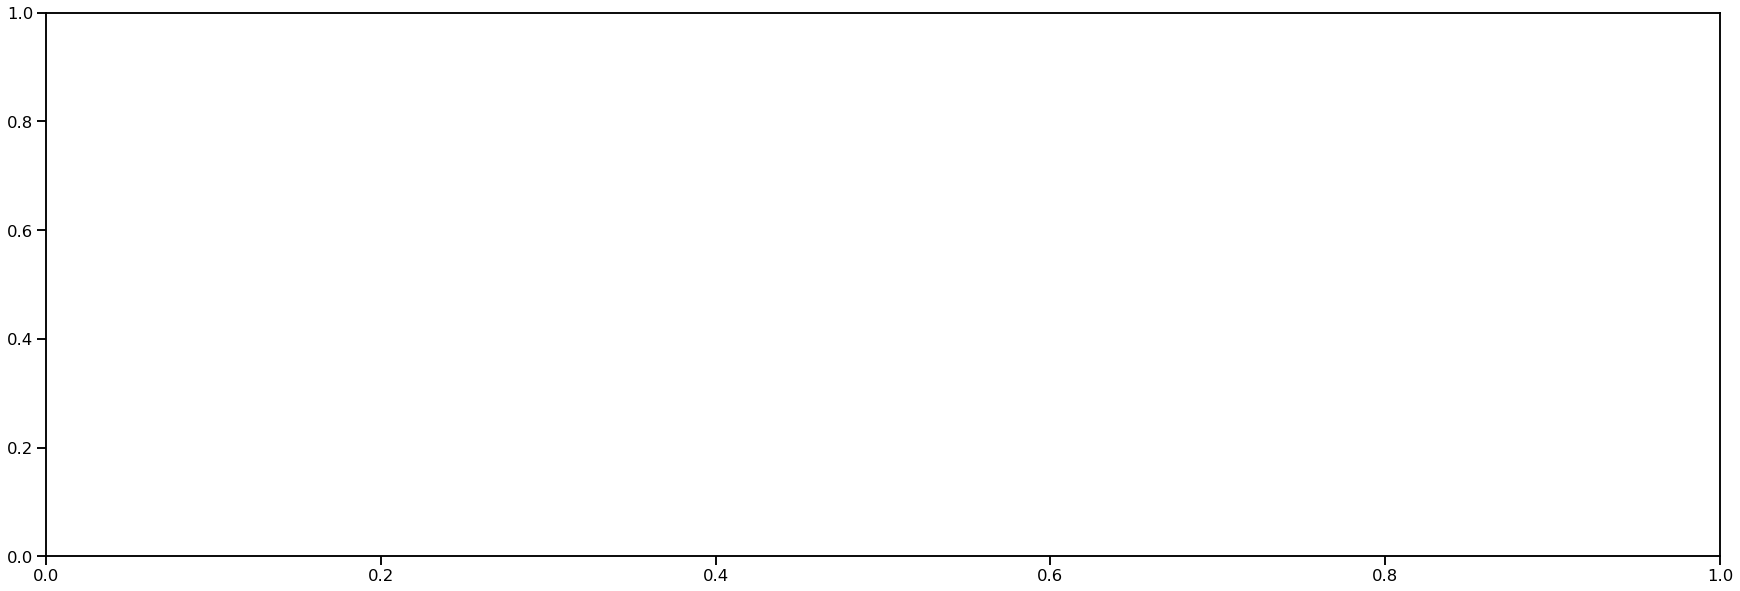

In [74]:
fig,ax=plt.subplots(figsize=(30,10))

Scatterplot to see if runtime minutes effects average rating

<AxesSubplot:xlabel='runtime_minutes', ylabel='averagerating'>

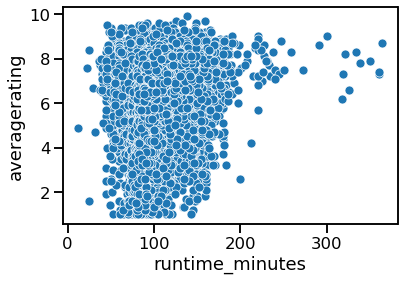

In [75]:
sns.scatterplot(data=df, x='runtime_minutes', y='averagerating')

See what the average rating is to see if we want to add a mean line to visualization

In [76]:
df_directors['avg_rating'].mean()

5.450439648281375

Create visualization for average rating and the number of directors who have that rating to understand the distribution of ratings

[Text(0.5, 0, 'Average rating'),
 Text(0, 0.5, 'Number of Directors'),
 Text(0.5, 1.0, 'Average rating distribution')]

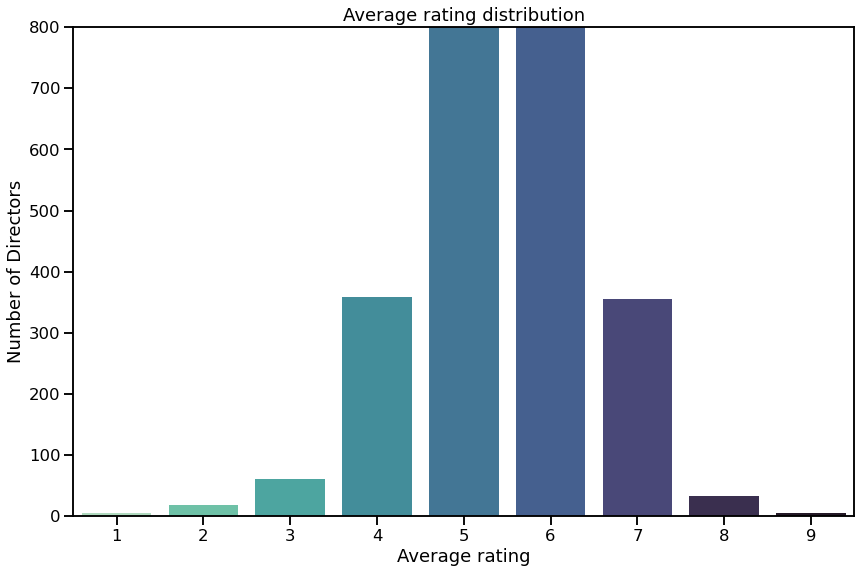

In [77]:
sns.set_context('talk')
fig,ax=plt.subplots(figsize=(14,9))
countplot=sns.countplot(
    data=df_directors,  
    x='avg_rating',
    order=[1,2,3,4,5,6,7,8,9],
    palette='mako_r'
    )
plt.ylim(0,800)
countplot.set(xlabel = "Average rating", ylabel='Number of Directors', title='Average rating distribution')

Visualization for smaller data set of top directors to see who the top directors are and what their ratings are

[Text(0.5, 0, 'Director'),
 Text(0, 0.5, 'Ratings'),
 Text(0.5, 1.0, 'Top Directors')]

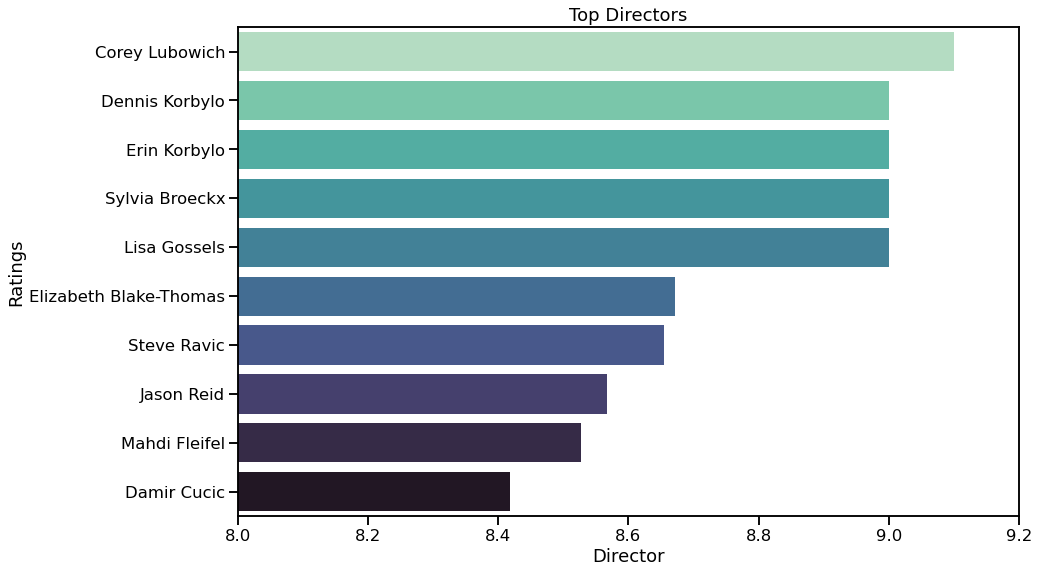

In [78]:
fig,ax=plt.subplots(figsize=(14,9))
barplot=sns.barplot(
    data=df_directors2, 
    y='name', 
    x='avg_rating',
    palette='mako_r'
    )
plt.xlim(8,9.2 )
sns.set_context('talk')
barplot.set(xlabel = "Director", ylabel='Ratings', title='Top Directors')

Another visual but no title this time because it is for powerpoint

[Text(0, 0.5, 'Director'), Text(0.5, 0, 'Ratings')]

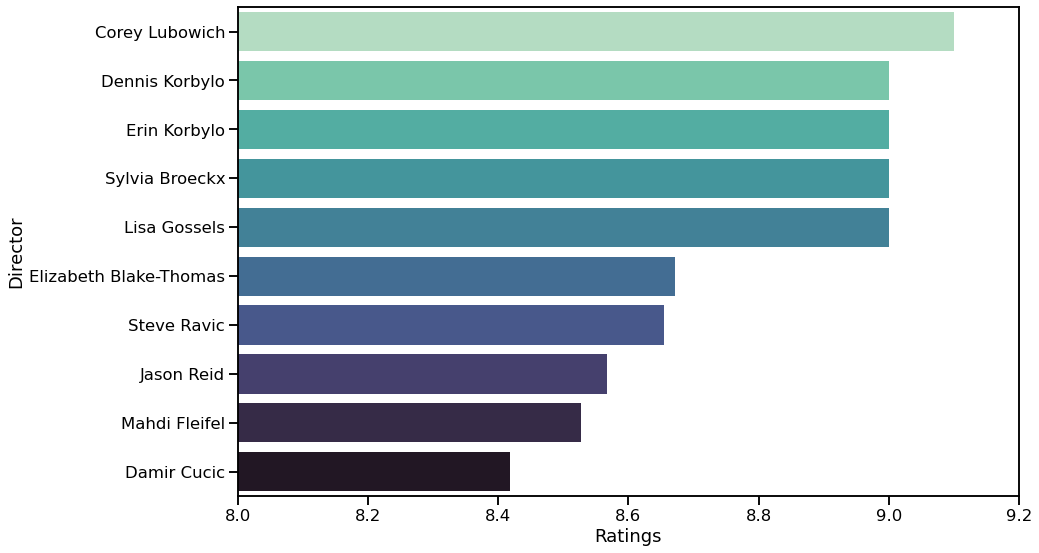

In [79]:
fig,ax=plt.subplots(figsize=(14,9))
barplot=sns.barplot(
    data=df_directors2, 
    y='name', 
    x='avg_rating',
    palette='mako_r'
    )
plt.xlim(8,9.2 )
barplot.set(ylabel = "Director", xlabel='Ratings')

Larger dataset visualization

<AxesSubplot:xlabel='director_id', ylabel='avg_rating'>

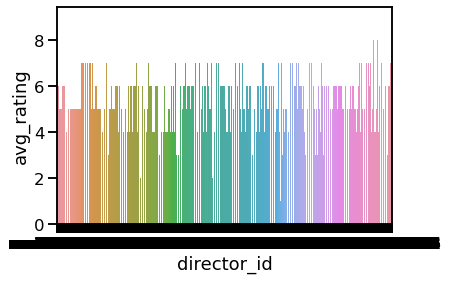

In [80]:
x=df_directors['director_id']
y=df_directors['avg_rating']
sns.barplot(
    data=df_directors, 
    x='director_id', 
    y='avg_rating'
    )

# Analysis Complete

Close connection

In [81]:
conn.close()